In [292]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

## Part 1: Initial Queries

As we can see from an initial query,the SF bikeshares dataset contains 983,648 individual bike trips. 

In [255]:
%%bigquery total_trips
#counts all bike rides in the dataset
SELECT count(*) AS total_trips
FROM `bigquery-public-data.san_francisco.bikeshare_trips`;

In [256]:
total_trips

total_trips
0       983648

The dataset is also a static dataset that spans from the morning of Aug. 29, 2013 to nearly midnight on August 31, 2016. This is important since we now know that we are dealing with a definitative set of figures that will not be updated as we progress through the analysis.

In [257]:
%%bigquery 
#finds the start date and end date for the dataset
SELECT min(start_date) AS start_date , max(end_date) AS end_date
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
WHERE duration_sec > 0; 

start_date                  end_date
0 2013-08-29 09:08:00+00:00 2016-08-31 23:48:00+00:00

The dataset contains 700 individual bikes. 

In [258]:
%%bigquery 
#counts the total number of bikes
SELECT count(DISTINCT bike_number) AS n_bikes
FROM `bigquery-public-data.san_francisco.bikeshare_trips`;

n_bikes
0      700

#### Advanced Questions of my own

In addition to these basic queries, it is important to understand the outliers in the dataset. To understand these cases, I conducted a query to show the number of bikerides that lasted over a day. In total there are 296 'rides' that last over a day. The longest a bike was rented for was nearly 200 days! We may want to throw out (or be aware) of these outliers during our research.

In [259]:
%%bigquery 
#Question 1: How many rideshares lasted over a day?
SELECT count(duration_sec) AS n_24hr_rides, max(duration_sec)/(60*60*24) AS max_ride
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
WHERE duration_sec >= 60*60*24;

n_24hr_rides    max_ride
0           296  199.888889

It is also important to understand the top destinations, as this may give us insights into whether people are traveling for leisure or for a commute. It turns out the top 2 locations are CalTrain locations and the Ferry Building. This shows that most trips are likely being used for commuting. 

In [260]:
%%bigquery top_destinations
#Question 2: What were the top bikeshare destinations? 
SELECT end_station_name AS end_station,
COUNT(trip_id) AS n_trips
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
GROUP BY end_station_name
ORDER BY n_trips DESC
LIMIT 10;

In [261]:
top_destinations

end_station  n_trips
0       San Francisco Caltrain (Townsend at 4th)    92014
1        San Francisco Caltrain 2 (330 Townsend)    58713
2           Harry Bridges Plaza (Ferry Building)    50185
3                         Embarcadero at Sansome    46197
4                                2nd at Townsend    44145
5                              Market at Sansome    40956
6                              Steuart at Market    39598
7                                Townsend at 7th    38545
8  Temporary Transbay Terminal (Howard at Beale)    35477
9                                  Market at 4th    26762

The last custom query shows how many customers there are versus subscribers. Customers are simply one off trips that are most likely used for leisure. Meanwhile subscribers are regular users that pay a monthly/yearly fee for the service. This doesn't mean that they are daily commuter users, but most commuters will likely be in this category as it would save them money in the long run. It turns out that there are 846,839 subscribers vs. 136,809 customers. This shows that most rides are likely meant for commuting. 

In [262]:
%%bigquery customer_type
# Question 3: What is the customer vs. subscriber mix? This may help with our commuter assumptions. 
SELECT subscriber_type  AS customer_type, count(subscriber_type)  AS n,
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
GROUP BY subscriber_type;

In [263]:
customer_type = customer_type.append(pd.Series(customer_type.sum(),name='Total'))
print(customer_type)

#for use later on
customers = customer_type.loc[0,"n"]
subscribers = customer_type.loc[1,"n"]
total_riders = customer_type.loc["Total","n"]

            customer_type       n
0                Customer  136809
1              Subscriber  846839
Total  CustomerSubscriber  983648


## Part 2: Querys from the BigQuery CLI

We redo the first three questions from the earlier dataset to help understand how to run BigQuery queries from the VM command line. 

This command line query shows that the SF bikeshares dataset contains 983,648 individual bike trips. 

In [264]:
# What is the size of the dataset?
! bq query --use_legacy_sql=FALSE --format=csv 'SELECT count(*) AS total_trips FROM `bigquery-public-data.san_francisco.bikeshare_trips`' > total_trips.csv

Waiting on bqjob_r797d99ae1a679d97_000001729149185e_1 ... (0s) Current status: DONE   


In [265]:
total_trips = pd.read_csv('total_trips.csv')
total_trips

total_trips
0       983648

Again, we see that the dataset goes from Aug. 29, 2013 to August 31, 2016.

In [266]:
# What is the earliest start time and the latest end time for a trip? 
! bq query --use_legacy_sql=FALSE --format=csv 'SELECT min(time) AS start_time, max(time) AS end_time FROM `bigquery-public-data.san_francisco.bikeshare_status`' > df_dates.csv

Waiting on bqjob_r71b11274f713d611_0000017291491f06_1 ... (0s) Current status: DONE   


In [267]:
dates = pd.read_csv('df_dates.csv')
dates

start_time             end_time
0  2013-08-29 12:06:01  2016-08-31 23:58:59

We also see that there are again 700 bikes in the rideshare system.

In [268]:
# How many bikes are there? 
! bq query --use_legacy_sql=FALSE --format=csv 'SELECT count(distinct bike_number) AS total_bikes FROM `bigquery-public-data.san_francisco.bikeshare_trips`'  > total_bikes.csv

Waiting on bqjob_r4d97e0dd9aa5008c_00000172914924f5_1 ... (0s) Current status: DONE   


In [269]:
n_bikes = pd.read_csv('total_bikes.csv')
n_bikes

total_bikes
0          700

In a bit of new analysis, we dived into how many morning trips there were versus afternoon trips. Using two Seperate queries, we found that there were 412,339 morning trips vs. 771,309 afternoon trips. This could be helpful as we may offer more morning offers to smooth this usage out. 

In [270]:
#How many trips are in the morning vs. the afternoon? 
! bq query --use_legacy_sql=FALSE --format=csv 'SELECT count(*) AS am_trips FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE EXTRACT (hour FROM start_date) < 12;' > am_trips.csv

Waiting on bqjob_r45ee313507348cb0_0000017291492b11_1 ... (0s) Current status: DONE   


In [271]:
! bq query --use_legacy_sql=FALSE --format=csv 'SELECT count(*) AS pm_trips FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE EXTRACT (hour FROM start_date) >= 12;' > pm_trips.csv

Waiting on bqjob_r41e366af7daf3fc3_00000172914930cc_1 ... (0s) Current status: DONE   


In [272]:
am_trips = pd.read_csv('am_trips.csv')
pm_trips = pd.read_csv('pm_trips.csv')
am_vs_pm = pd.concat([am_trips, pm_trips])
print(am_trips)
print(pm_trips)

   am_trips
0    412339
   pm_trips
0    571309


### Project Questions

#### Question A: What are the most frequent commuter trips?

The first question we should ask is 'What are the most frequent commuter trips?' In order to find the most common commmuter trips, I used SQL to narrow the top destinations by select criteria. These criteria (and their reasoning) are as follows: 

1. Customer type is a subscriber - Subscribers go on the most frequent amount of trips. We are assuming that commuters are making these trips every weekday or at least several times a week. They would therefore save more money as a subscriber and would do that package. 
2. Duration is between 10-60 mins. - If the commuter's trip is less than 10 mins. I assume they would rather walk. Bike rides longer than 60 mins. are likely too streneous for an average person's daily commmute.
3. Different start and end points - Commuters are trying to go from point a to point b. Thus, a commuter trip wouldn't return a bike to its original starting point. 

In [309]:
%%bigquery top_c_trips

# Question 1: What is the most common commuter trips (based on commuter parameters? 
SELECT start_station_name, end_station_name, COUNT(*) AS count
FROM `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips`
WHERE
  subscriber_type="Subscriber"
    AND duration_sec >= 60*10 AND duration_sec <= 60*60
    AND start_station_name != end_station_name
GROUP BY start_station_name, end_station_name
ORDER BY count DESC
LIMIT 100;

In [338]:
print("Top Bikeshare Trips\n")
! bq query --use_legacy_sql=FALSE --format=csv 'SELECT start_station_name, end_station_name, count(*) as trip_freq FROM `bigquery-public-data.san_francisco.bikeshare_trips` GROUP BY start_station_name, end_station_name ORDER BY trip_freq DESC LIMIT 20' > result.csv
top_c_trips = top_c_trips.head(20)
top_c_trips

Top Bikeshare Trips

Waiting on bqjob_r1398a8e06330a28c_0000017291958625_1 ... (0s) Current status: DONE   


start_station_name  \
0            Harry Bridges Plaza (Ferry Building)   
1                               Steuart at Market   
2        San Francisco Caltrain (Townsend at 4th)   
3        San Francisco Caltrain (Townsend at 4th)   
4         San Francisco Caltrain 2 (330 Townsend)   
5        San Francisco Caltrain (Townsend at 4th)   
6                           Embarcadero at Folsom   
7   Temporary Transbay Terminal (Howard at Beale)   
8        San Francisco Caltrain (Townsend at 4th)   
9                                 Clay at Battery   
10                                Beale at Market   
11                               Davis at Jackson   
12                              Steuart at Market   
13                      Broadway St at Battery St   
14       San Francisco Caltrain (Townsend at 4th)   
15       San Francisco Caltrain (Townsend at 4th)   
16                                 Market at 10th   
17  Temporary Transbay Terminal (Howard at Beale)   
18        San Francisco Caltrain 2 (330 Townsend)   
19                                Townsend at 7th   

                                 end_station_name  count  
0        San Francisco Caltrain (Townsend at 4th)   4518  
1        San Francisco Caltrain (Townsend at 4th)   4442  
2            Harry Bridges Plaza (Ferry Building)   4387  
3   Temporary Transbay Terminal (Howard at Beale)   3523  
4                                  Market at 10th   3449  
5                               Steuart at Market   3181  
6        San Francisco Caltrain (Townsend at 4th)   3030  
7        San Francisco Caltrain (Townsend at 4th)   2885  
8                                Davis at Jackson   2584  
9        San Francisco Caltrain (Townsend at 4th)   2532  
10       San Francisco Caltrain (Townsend at 4th)   2497  
11       San Francisco Caltrain (Townsend at 4th)   2475  
12        San Francisco Caltrain 2 (330 Townsend)   2397  
13       San Francisco Caltrain (Townsend at 4th)   2302  
14                                 Market at 10th   2298  
15                          Embarcadero at Folsom   2162  
16        San Francisco Caltrain 2 (330 Townsend)   2153  
17                                Townsend at 7th   2058  
18           Harry Bridges Plaza (Ferry Building)   2032  
19           Harry Bridges Plaza (Ferry Building)   1996

As we can see from the top_c_trips dataframe, the top commuter trips are difficult to understand. This is because trips could technically be counted both ways. For example the trip Steuart at Market <-> SF CalTrain (Townsend at 4th) is double counted in this table, one for each direction. In order to further understand the top routes. We broke this graph into a pivot table so that we could produce a heat map showing the most traversed paths.

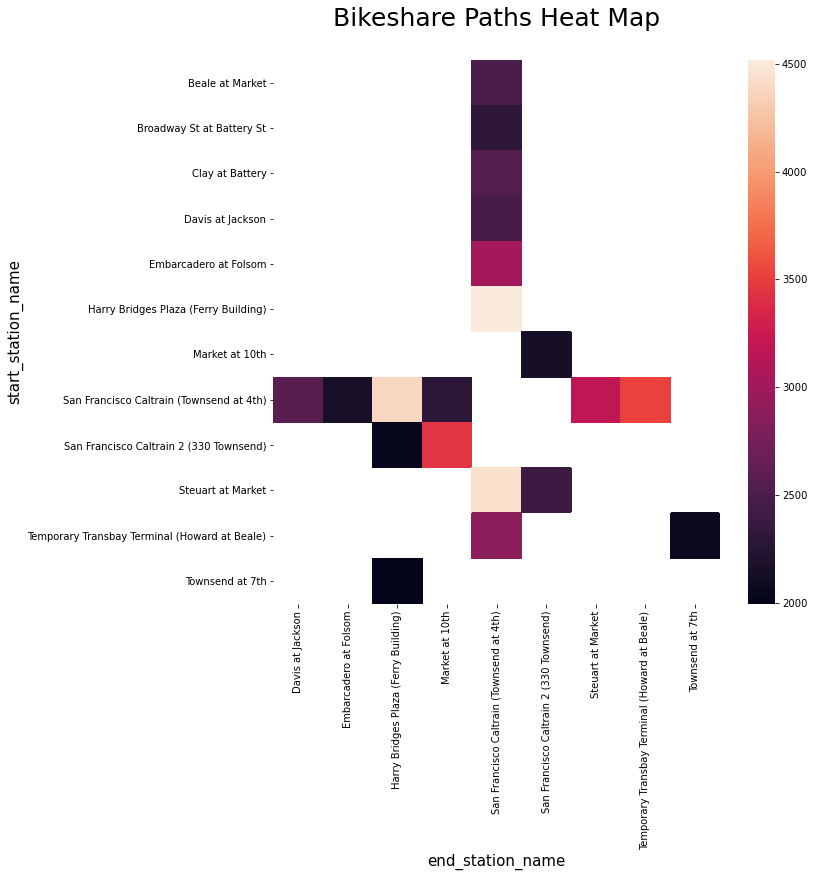

In [326]:
plt.figure(figsize=(10,10))
c_trips_pivot = top_c_trips.pivot("start_station_name","end_station_name","count")
c_trips_pivot = c_trips_pivot.dropna(axis=0,how='all')
plt.xlabel("Start Station", size=15)
plt.ylabel("End Station", size=15)
plt.title("Bikeshare Paths Heat Map\n", size=25)
sns.heatmap(c_trips_pivot)


The heatmap above is not perfect, but gives us a better sense into which routes are the most traveled. Eliminating duplicate values, **we see that the following routes are the most popular bike paths:** 
1. Harry Bridges Plaza <-> SF CalTrain (Townsend at 4th), 8905 trips
2. Steuart at Market <-> SF CalTrain (Townsend at 4th), 7623 trips
3. Temporary Transbay Terminal <-> SF CalTrain (Townsend at 4th), 6408 trips
4. Market at 10th <-> SF CalTrain (330 Townsend), 5602 trips
5. Embarcadero at Folsom <-> SF CalTrain (Townsend at 4th), 5192 trips

Additionally, we should be asking 'What percent of all commuter trips go to these top 100 destinations?' We should also be looking to see what percentage of ALL total trips go to these top 100 commuter destinations. 

In [327]:
# Question 2: For the Top 100 Commuter Trips, what percent are they of all commuter trips? 
top_100_vs_all_commutes = top_c_trips['count'].sum()
print("Top 100 Commuter Trips as Percentage of All Commuter Trips:\n", float(top_100_vs_all_commutes/subscribers))

Top 100 Commuter Trips as Percentage of All Commuter Trips:
 0.06719222898331324


In [328]:
# Question 3: What percent of all trips can be attributed to the top 100 rides?
print("Top 100 Commuter Trips as Percentage of All Trips:\n", top_100_vs_all_commutes/total_riders)

Top 100 Commuter Trips as Percentage of All Trips:
 0.0578469127167442


The queries above show us that  the top 100 "commuter trips" account for only ~15% of all bike rides and only ~17% of all commuter rides. This is important as it shows that bike rides are relatively distributed and that we should be looking to attract deals not just in hot spots, but elsewhere as well.

### Project Question Part b: What offers can we share with commuters to increase usage and revenues? 

First, it is important to understand how long the average ride takes. It may be worthwhile to explore a discount for longer rides that are still obtainable. 

In [281]:
%%bigquery trip_times
# Question 4: How long are bike rides (included graphs)
SELECT duration_sec/60 AS mins
FROM `bigquery-public-data.san_francisco.bikeshare_trips`

In [291]:
trip_times.head(100)

mins
0    43.633333
1    99.283333
2    98.550000
3   101.316667
4    96.333333
..         ...
95    4.716667
96    3.683333
97    4.383333
98    5.200000
99    4.500000

[100 rows x 1 columns]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f37db47df50>]],
      dtype=object)

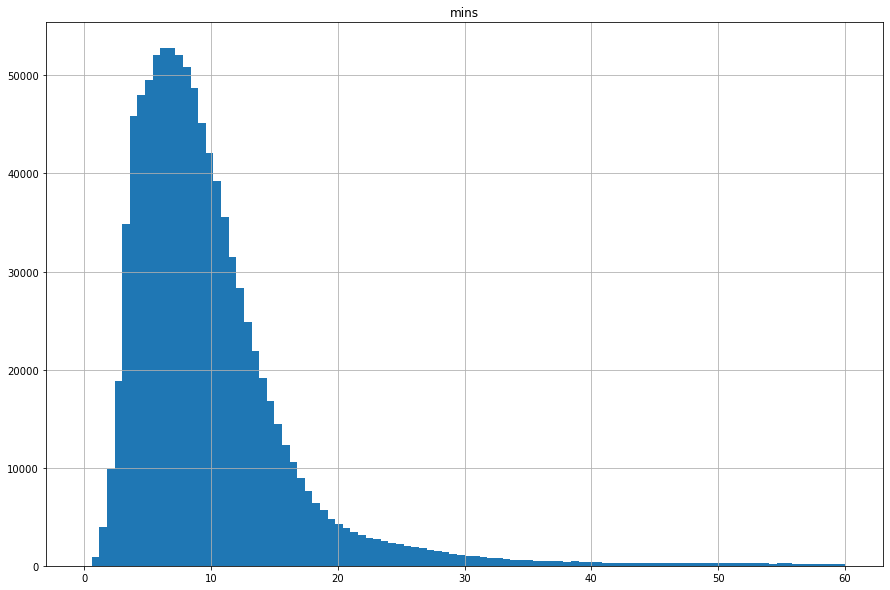

In [290]:
trip_times.hist(range=[0,60], bins=100, figsize=(15,10))

As we can see, the vast majority (>90%) of rides last less than 20 minutes. We may be able to provide a discount for rides that last longer than 20 minutes to incentive longer run times. Monthly and Annual  members receive 45min. rides for free whenever they want. As a result, it should target the more lucritive single ride and one time access pass pricing tiers. Instead of charging $3 more after 30 mins. it could charge $2 for example. 

Additionally, the supply and demand of bikes and docks may be concentrated in certain areas of the city. The access pass is designed to help people "go explore the city" and could be used to influence bike-users to go to new places and help with the amount of docks available. In order to explore this, we should first ask, which station have the most bikes available? Could we expand the access pass to include docks that are more readily available? 

In [332]:
%%bigquery d_available
# Question 5: What stations have the most docks available? 
SELECT MAX(docks_available) AS n_docks, station_id
FROM `bigquery-public-data.san_francisco.bikeshare_status`
# Try to join with stations name and location if possible
GROUP BY station_id
ORDER BY MAX(docks_available) DESC
LIMIT 100;

Most importatnly, we need to see where there are ride downtimes. This is shown by the number of docks available at each individual station. With this level of information, we can target specific promotions during those downtimes to increase usage. The following query produces a graph that shows the most noticable downtimes.  

    n_docks  station_id
0        35          25
1        34          91
2        31          26
3        30          90
4        27          67
..      ...         ...
70       11           4
71       11          35
72       11          37
73       11          32
74        0          87

[75 rows x 2 columns]


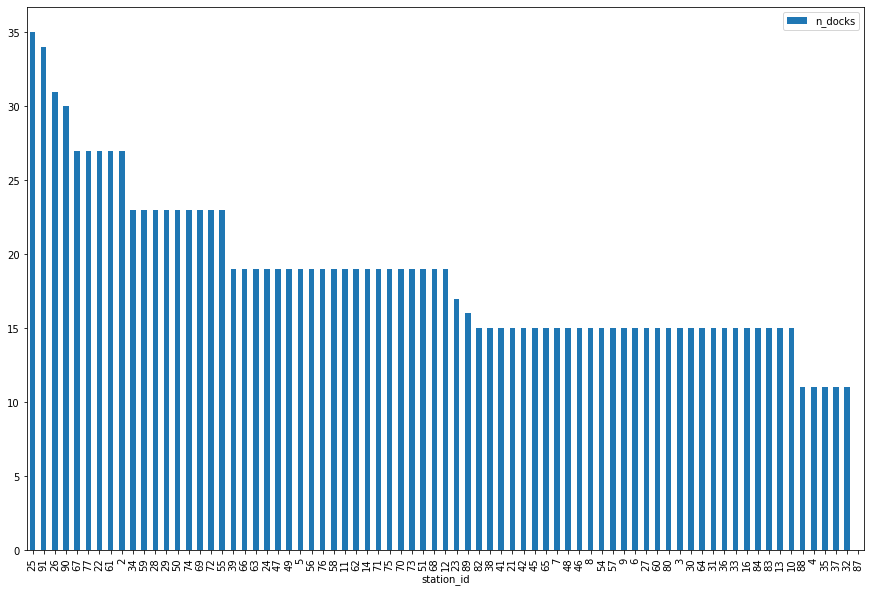

In [333]:
print(d_available)

ax = d_available.plot.bar(x="station_id", y="n_docks", figsize=(15,10))

We should target the access pass potentially for riders whose final destinations are at docks 25, 91, 26, and 90. These are in heavily targeted regions that will be used quickly. 




Lastly, we will see when people ride. There are massive disparities of when people ride and the bikeshare service can target discounts at times when there is more bike availability. 

In [334]:
%%bigquery bike_usage_by_time
# Question 6: When do people ride? Produces a chart to show rush hour dynamics
    SELECT subscriber_type, EXTRACT(HOUR FROM start_date) AS hour, COUNT(*) AS n
    FROM `bigquery-public-data.san_francisco.bikeshare_trips`
    GROUP BY hour, subscriber_type
    ORDER BY hour ASC

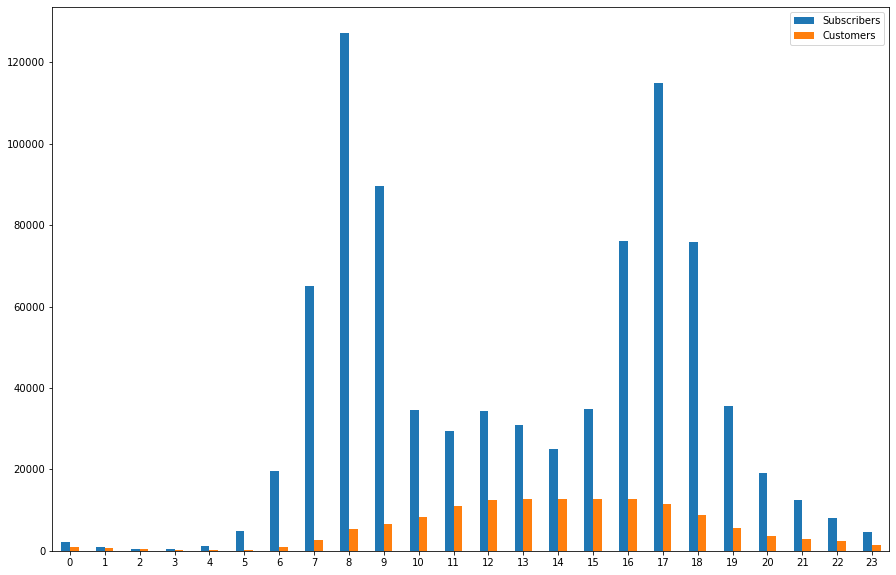

In [335]:
s = bike_usage_by_time[bike_usage_by_time.subscriber_type == "Subscriber"]
s_n = list(s["n"])
c = bike_usage_by_time[bike_usage_by_time.subscriber_type == "Customer"]
c_n = list(c["n"])

df = pd.DataFrame({'Subscribers': s_n,
                   'Customers': c_n})
ax = df.plot.bar(rot=0, figsize=(15,10))

As we can see from the graph above, there is a huge rush hour spike for subscribers who are most liklely commuters. Meanwhile,the customer section follows a normal distribution around 12 o'clock. While it would be great to offer promotions at night, this is not tenible since bikesharing becomes much more dangerous at night. 

As a result, the bikeshare service should focus targeted promotions for its single ride pricing tier between the hours of 11 and 16. In particular, it should look into running promotions for rides over 30 minutes. It could even expand its "Bikeshare for All" promotion for lower-income individuals. It could also provide the same promotions to subscribers, however it may not be as effective for those that are at work. This will allow the bikeshare service to keep usage higher during non-peak hours. 